# Install

In [1]:
! pip install fastai2 -q

     |████████████████████████████████| 194kB 4.7MB/s 


# Import

In [0]:
from fastai2.data.external import untar_data, URLs
from fastai2.data.transforms import get_image_files

# Dataset

In [3]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")
len(files), files[0]

(7390, Path('/root/.fastai/data/oxford-iiit-pet/images/Bombay_171.jpg'))

# Preparing Data

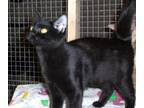

In [4]:
import PIL
img = PIL.Image.open(files[0])
img

In [0]:
import torch
import numpy as np

## Open image files

In [0]:
def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2, 0, 1).float()/255.0

In [7]:
t = open_image(files[0])
t.shape

torch.Size([3, 224, 224])

## Labeling

In [0]:
import re

In [0]:
def label_func(fname):
    return re.match(r'^(.*)_\d+\.jpg$', fname.name).groups()[0]

In [10]:
l = label_func(files[0])
l

'Bombay'

In [11]:
labels = list(set(files.map(label_func)))
len(labels)

37

## Creating util dict

In [0]:
lbl2files = {l: [f for f in files if label_func(f) == l] for l in labels}

In [0]:
# lbl2files

# Creating Custom Dataset

In [0]:
import random

## Define SiameseDataset class

In [0]:
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, files, is_valid=False):
        self.files, self.is_valid = files, is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]

    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls])
        return random.choice(lbl2files[cls]), same

    def __getitem__(self, i):
        file1 = self.files[i]
        (file2, same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1, img2 = open_image(file1), open_image(file2)
        return (img1, img2, torch.Tensor([same]).squeeze())

    def __len__(self):
        return len(self.files)

## Split

เอาเลข Running ตามจำนวนไฟล์ มา สับไพ่ Random แล้วเลือกตัดเป็น 2 ส่วน 80/20 นำมาใช้ดึงรายการไฟล์ใส่ Training Set / Validation Set

In [0]:
idxs = np.random.permutation(range(len(files)))
cut = int(0.8 * len(files))
train_files = files[idxs[:cut]]
valid_files = files[idxs[cut:]]

นำข้อมูลรายการไฟล์ที่ได้ มาสร้าง Dataset 2 SiameseDataset

In [0]:
train_ds = SiameseDataset(train_files)
valid_ds = SiameseDataset(valid_files, is_valid=True)

# DataLoaders

ใช้ 2 Dataset ที่ได้มาสร้าง DataLoaders

In [0]:
from fastai2.data.core import DataLoaders

In [19]:
dls = DataLoaders.from_dsets(train_ds, valid_ds)
dls

เรายังเรียก show_batch ไม่ได้ เพราะยังไม่ได้กำหนดวิธีแสดงผล เราจะลองดึงข้อมูลดู ด้วย one_batch

In [0]:
b = dls.one_batch()
# b

ถ้าต้องการให้ DataLoaders ของเรา ย้ายข้อมูลไปใช้ GPU ก็เพียงแค่สั่ง

In [21]:
dls.cuda()

# Transform

ในวิธีการเดียวกันกับที่เราสร้าง SiameseDataset เราสามารถนำมาสร้าง Transform เพื่อใช้ใน Data Pipeline สำหรับป้อนให้โมเดล

In [0]:
from fastai2.vision.all import *

In [0]:
class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        self.files, self.is_valid = files, is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
    
    def encodes(self, i):
        file1 = self.files[i]
        (file2, same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1, img2 = open_image(file1), open_image(file2)
        return (TensorImage(img1), TensorImage(img2), Tensor([same]).squeeze())

    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls])
        return random.choice(lbl2files[cls]), same

In [0]:
train_tl = TfmdLists(range(len(train_files)), SiameseTransform(train_files))
valid_tl = TfmdLists(range(len(valid_files)), SiameseTransform(valid_files, is_valid=True))

In [0]:
# train_tl

In [0]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])
# dls

In [27]:
dls.cuda()

# Show

In [0]:
class SiameseImage(Tuple):
    def show(self, ctx=None, **kwargs):
        img1, img2, same_breed = self
        if not isinstance(img1, Tensor): 
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1, t2 = tensor(img1), tensor(img2)
            t1, t2 = t1.permute(2, 0, 1), t2.permute(2, 0, 1)
        else: t1, t2 = img1, img2 
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1, line, t2], dim=2), title=same_breed, ctx=ctx, **kwargs)
        

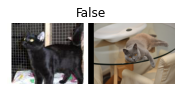

In [29]:
img = PILImage.create(files[0])
img1 = PILImage.create(files[1])
s = SiameseImage(img, img1, False)
s.show();

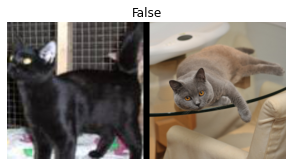

In [30]:
tst = Resize(224)(s)
tst = ToTensor()(tst)
tst.show();

# เปลี่ยน Transform ไปใช้ SiameseImage

เปลี่ยน Transform ไปใช้ SiameseImage จะได้สามารถโชว์ได้ เหมือนด้านบน

In [0]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
    def encodes(self, f):
        f2, same = self.valid.get(f, self._draw(f))
        img1, img2 = PILImage.create(f), PILImage.create(f2)
        return SiameseImage(img1, img2, same)

    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls))
        return random.choice(lbl2files[cls]), same

In [0]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)

In [0]:
tls = TfmdLists(files, tfms=tfm, splits=splits)

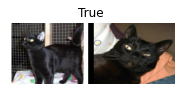

In [34]:
show_at(tls, 0)

In [0]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

แต่ตอนนี้ยัง show_batch ไม่ได้ เนื่องจาก

In [36]:
b = dls.one_batch()
type(b)

__main__.SiameseImage

สังเกต Type Annotation SiameseImage บน x

In [0]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], x[2][i].item()).show(ctx=ctx)

In [0]:
b = dls.one_batch()

In [39]:
dls._types

{__main__.SiameseImage: [fastai2.torch_core.TensorImage,
  fastai2.torch_core.TensorImage,
  torch.Tensor]}

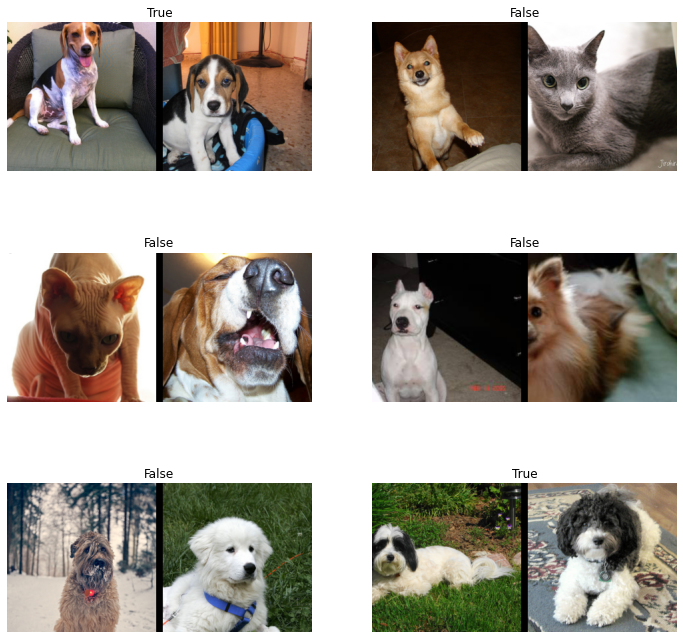

In [40]:
dls.show_batch()

# Creating Custom DataBlock

In [0]:
class ImageTuple(Tuple):
    @classmethod
    def create(cls, fns): return cls(tuple(PILImage.create(f) for f in fns))

    def show(self, ctx=None, **kwargs):
        t1, t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx 
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1, line, t2], dim=2), ctx=ctx, **kwargs)

In [42]:
img = ImageTuple.create((files[0], files[1]))
tst = ToTensor()(img)
type(tst), type(tst[0]), type(tst[1])

(__main__.ImageTuple,
 fastai2.torch_core.TensorImage,
 fastai2.torch_core.TensorImage)

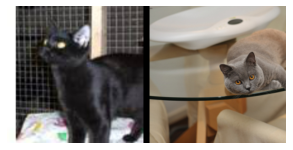

In [43]:
img1 = Resize(224)(img)
tst = ToTensor()(img1)
tst.show();

In [0]:
def ImageTupleBlock(): 
    return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)

In [0]:
def draw_other(f):
    same = random.random() < 0.5
    cls = label_func(f)
    if not same: cls = random.choice(L(l for l in labels if l != cls))
    return random.choice(lbl2files[cls]), same

In [0]:
def get_tuple_files(path):
    files = get_image_files(path)
    return [[f, *draw_other(f)] for f in files]

In [0]:
def get_x(t): return t[:2]
def get_y(t): return t[2]

In [0]:
siamese = DataBlock(
    blocks=(ImageTupleBlock, CategoryBlock), 
    get_items=get_tuple_files, 
    get_x=get_x, 
    get_y=get_y, 
    splitter=RandomSplitter(), 
    item_tfms=Resize(224), 
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

In [0]:
dls = siamese.dataloaders(path/"images", path=path)

In [50]:
b = dls.one_batch()
explode_types(b)

{tuple: [{__main__.ImageTuple: [fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage]},
  fastai2.torch_core.TensorCategory]}

In [0]:
@typedispatch
def show_batch(x:ImageTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

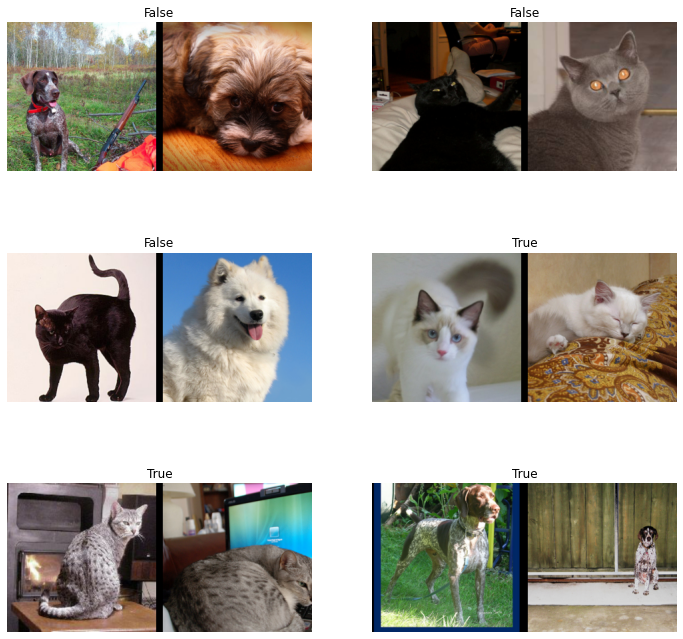

In [52]:
dls.show_batch()

# Training a Model

In [0]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder, self.head = encoder, head

    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)],  dim=1)
        return self.head(ftrs)

In [54]:
model_meta[resnet34]

{'cut': -2,
 'split': <function fastai2.vision.learner._resnet_split>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [55]:
encoder = create_body(resnet34, cut=-2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [56]:
encoder[-1]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

Output จาก Encoder มีขนาด 512 Features เราจะต้องสร้าง Head ที่มี Input ขนาด 512 * ( 2 * 2 ) และ Output 2 Class

2 ตัวแรก มาจาก เรามี 2 โมเดลคู่ขนาดกันเป็นแฝด Siamese, 2 ตัวหลัง มาจาก Fastai ใช้ Max Pool + Average Pool มา Concat กัน

In [57]:
head = create_head(512*4, 2, ps=0.5)
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [0]:
model = SiameseModel(encoder, head)

Define how to split the model params

In [0]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

ใช้ Cross Entropy Loss ตามปกติ (แบบ Flatten)

In [0]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

กำหนด Transform สำหรับดึงข้อมูล

In [0]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.valid = {f: self._draw(f) for f in files[splits[1]]}

    def encodes(self, f):
        f2, t = self.valid.get(f, self._draw(f))
        img1, img2 = PILImage.create(f), PILImage.create(f2)
        return SiameseImage(img1, img2, int(t))

    def _draw(self, f):
        same = random.random() > 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls))
        return random.choice(lbl2files[cls]), same

In [0]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [0]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter, metrics=accuracy).to_fp16()

In [0]:
learn.freeze()

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=9.12010818865383e-07)

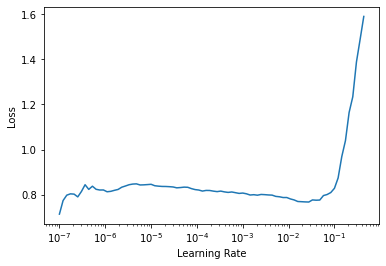

In [65]:
learn.lr_find()

In [66]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.561520,0.380326,0.849120,01:19
1,0.370464,0.235870,0.910690,01:19
2,0.287073,0.203848,0.924899,01:18
3,0.258784,0.179383,0.930988,01:19


In [0]:
learn.unfreeze()

In [68]:
learn.fit_one_cycle(4, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.235477,0.180125,0.930988,01:22
1,0.221360,0.172202,0.935724,01:23
2,0.229311,0.164998,0.936401,01:22
3,0.217518,0.167056,0.935724,01:23


# Show Results

คล้าย ๆ กับ show_batch แต่มีการ compose title เอา x[2], y[2] มาใส่

x[0] คือ รูปแรก, x[1] คือ รูปสอง, x[2] คือ label ว่า same หรือไม่

In [0]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'{[False,True][x[2][i].item()]}\n{[False,True][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

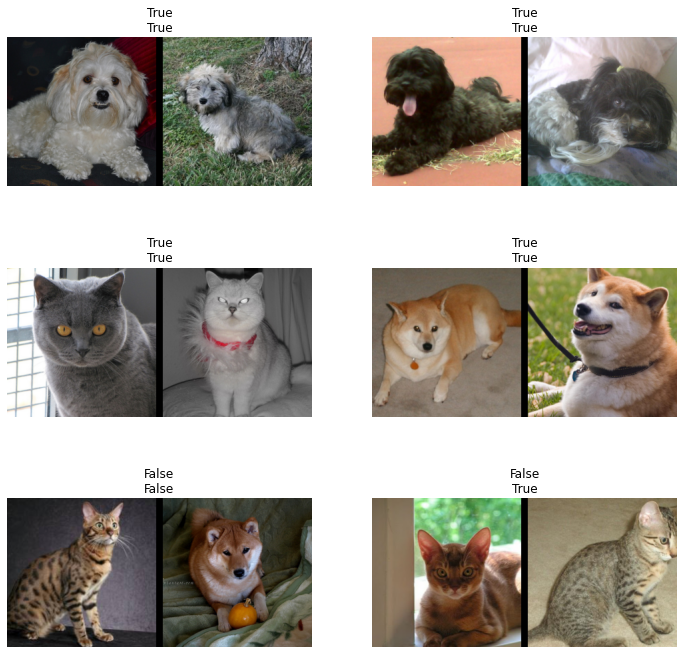

In [70]:
learn.show_results()

# Credit 

* https://dev.fast.ai/tutorial.siamese